In [1]:
from helper_loader import *

In [2]:
def interpolate_sparse_3d_array(
    array: np.ndarray,
    reference_mask: Optional[np.ndarray] = None,
    pre_masked: bool = False,
    kernel: str = "multiquadric",
    neighbours: int = 27,
    epsilon: int = 1,
    degree: Optional[int] = None,
    chunk_size: Optional[int] = 1_000_000,
    recursive: bool = False,
) -> np.ndarray:
    if reference_mask is not None and (array_shape := array.shape) != (
        reference_shape := reference_mask.shape
    ):
        raise ValueError(
            f"Array and reference mask have different shapes "
            f"({array_shape} vs {reference_shape})."
        )

    # Mask the array if necessary
    if reference_mask is not None and not pre_masked:
        array = np.where(reference_mask, array, 0)

    interpolated_array = array.copy()
    interpolated_array = interpolated_array.astype(np.float64)

    if reference_mask is None:
        # Interpolate the whole grid
        target_coordinates = tuple(
            array.flatten().astype(int)
            for array in np.meshgrid(
                np.linspace(
                    0, interpolated_array.shape[0] - 1, interpolated_array.shape[0]
                ),
                np.linspace(
                    0, interpolated_array.shape[1] - 1, interpolated_array.shape[1]
                ),
                np.linspace(
                    0, interpolated_array.shape[2] - 1, interpolated_array.shape[2]
                ),
                indexing="ij",
            )
        )
    else:
        # Interpolate only non-zero coordinates of mask
        target_coordinates = np.nonzero(reference_mask)
    target_points = np.array(target_coordinates).T

    if chunk_size is None:
        chunk_size = target_points.shape[0]

    logging.info("Starting interpolation.")

    failed_chunks = []
    previous_target_size = target_points.shape[0]
    while True:
        known_coordinates = np.nonzero(interpolated_array)
        known_points = np.array(known_coordinates).T

        known_values = array[known_coordinates]

        interpolator = RBFInterpolator(
            known_points,
            known_values,
            kernel=kernel,
            neighbors=neighbours,
            epsilon=epsilon,
            degree=degree,
        )

        chunk_start = 0
        chunk_end = chunk_size
        chunk_index = 1
        chunk_count = math.ceil(target_points.shape[0] / chunk_size)
        while chunk_start < target_points.shape[0]:
            logging.info(
                f"Interpolating chunk {chunk_index}/{chunk_count} "
                f"({chunk_index / chunk_count:.0%})."
            )

            chunk_coordinates = tuple(
                coordinate[chunk_start:chunk_end] for coordinate in target_coordinates
            )
            chunk_points = target_points[chunk_start:chunk_end]

            try:
                interpolated_array[chunk_coordinates] = interpolator(chunk_points)
            except np.linalg.LinAlgError:
                failed_chunks.append([chunk_start, chunk_end])
                logging.info(f"Failed to interpolate chunk {chunk_index}.")

            chunk_start += chunk_size
            chunk_end += chunk_size
            chunk_index += 1

        if not recursive or len(failed_chunks) == 0:
            break

        # Prepare the next loop
        target_coordinates = tuple(
            np.concatenate(
                [target_coordinate[start:end] for start, end in failed_chunks]
            )
            for target_coordinate in target_coordinates
        )
        target_points = np.array(target_coordinates).T
        failed_chunks = []

        # Avoid infinitely looping
        if previous_target_size == target_points.shape[0]:
            logging.error(
                f"Interpolation is not fully solvable with current combination of "
                f"kernel, neighbours parameter and chunk size. "
                f"Returning current result."
            )
            break
        previous_target_size = target_points.shape[0]

        logging.info(
            f"There were {len(failed_chunks)} failed chunks of size {chunk_size}. "
            f"Recursing with newly interpolated data."
        )

    return interpolated_array

In [3]:
volume_path = Path("resources/d2783eb27223868f57e159f01ce7a1b2.npz")

In [4]:
aligned_array = np.load(volume_path)["array"]
atlas_array = load_volume(
    get_structure_mask_path("root", Resolution.MICRONS_25),
    return_raw_array=True,
)

In [5]:
focused_area = (
    (atlas_array.shape[0] // 5 * 2, atlas_array.shape[0] // 5 * 3),
    (atlas_array.shape[1] // 5 * 2, atlas_array.shape[1] // 5 * 3),
    (atlas_array.shape[2] // 8, atlas_array.shape[2] // 3),
)
focused_shape = (area_array := np.array(focused_area).T)[1] - area_array[0]
focused_slice = tuple(slice(focus[0], focus[1]) for focus in focused_area)

focused_array = np.zeros_like(atlas_array)
focused_array[focused_slice] = np.ones(shape=focused_shape)

In [6]:
aligned_array_cropped = np.where(focused_array, aligned_array, 0)
atlas_array_cropped = np.where(focused_array, atlas_array, 0)

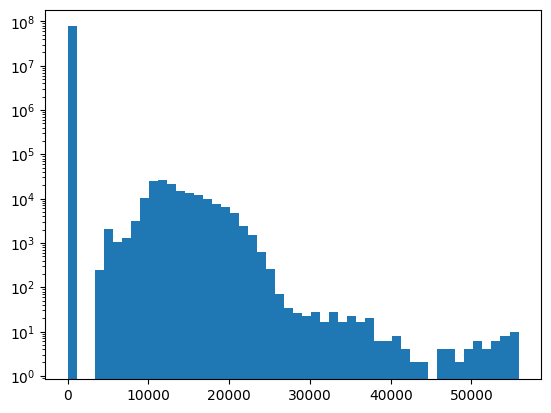

In [63]:
hist(aligned_array_cropped.flatten(), bins=50, log=True)

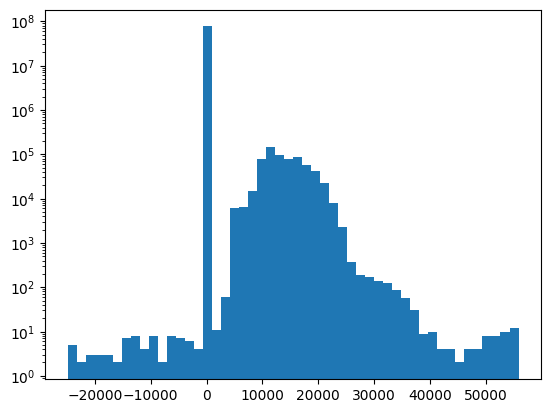

In [64]:
linear_interpolated_array = interpolate_sparse_3d_array(
    aligned_array_cropped,
    reference_mask=atlas_array_cropped,
    kernel="linear",
)

hist(linear_interpolated_array.flatten(), bins=50, log=True)

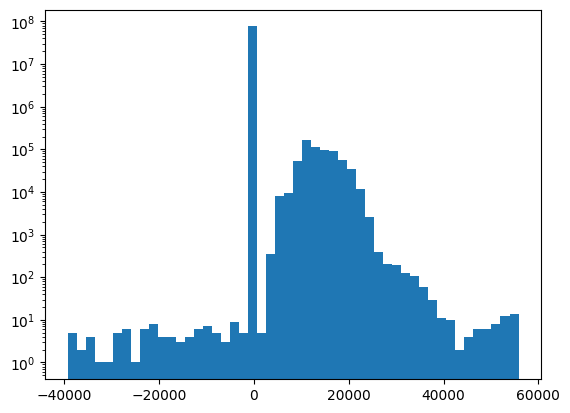

In [65]:
multiquadric_interpolated_array = interpolate_sparse_3d_array(
    aligned_array_cropped,
    reference_mask=atlas_array_cropped,
    kernel="multiquadric",
)

hist(multiquadric_interpolated_array.flatten(), bins=50, log=True)

In [42]:
known_coordinates = np.nonzero(np.where(focused_array, aligned_array, 0))
known_values = aligned_array[known_coordinates]

interpolated_values = linear_interpolated_array[known_coordinates]

np.mean(np.abs(known_values - interpolated_values))

2.696736813405382e-12

In [45]:
known_coordinates = np.nonzero(np.where(focused_array, aligned_array, 0))
known_values = aligned_array[known_coordinates]

interpolated_values = linear_interpolated_array[known_coordinates]

np.mean(np.abs(known_values - interpolated_values))

0.0

In [50]:
def update(index: int = 0) -> None:
    imshow(aligned_array_cropped[..., index].T, title="Aligned")
    imshow(linear_interpolated_array[..., index].T, title="Linear")


interact(update, index=(0, 94));

interactive(children=(IntSlider(value=0, description='index', max=94), Output()), _dom_classes=('widget-intera…